---


<font size="32"><p>Analysis of <p>Historical Financial Option Price Data <p> Using Python </font>

---

**Table of Contents**

1. [Intro](#Intro)

2. [Historical SPX Data Analysis](#Historical-SPX-Data-Analysis)
  1. [Data Transformations](#Data-Transformations)
  1. [Quick Stats](#Quick-Stats)


3. [Option Price Calculators](#Option_Price_Calculators)
  1. [Black-Scholes Formulas](#Black-Scholes-Formulas)
  1. [Binary Option Pricing Model](#Binary-Option-Pricing-Model)
  1. [Implied Volatility Calculation](#Implied-Volatility-Calculation)


4. [Option Formulas Applied to SPX](#Option-Formulas-Applied-to-SPX)


5. [India's Nifty 50](#India's-Nifty-50)
  1. [Underlying Index Data](#Underlying-Index-Data)
  2. [Option Data](#Option-Data)

# Intro

The purpose of this notebook is to show how Python can be used to analyze Financial Option data. Pandas offers a familiar and powerful toolkit for big data analysis. Also, a number of Python modules enable quick retrieval of financial data (e.g., quandl, nsepy, pandas_datareader), which facilitates collection and preparation of big data for analysis and modeling. Overall, we hope the reader will agree that the Python ecosystem is useful for financial market data analysis as well.


To compare results with theoretical values I include functions to compute theoretical option prices using the Black-Scholes model and the Binary Option Value model. For the purposes of this analysis Python is sufficiently fast.

**UPDATE:** Within days of this writeup (India's NSE Blocked Free Data Access). So this notebook cannot be replicated (at least for free).

## Outline

- **Analyze historical data about SP500 Vanilla Options**

Leverage historical SPX Option Data
from https://www.historicaloptiondata.com/content/sample-files-0

This data includes the usual option price data and additional information like implied volatility and option greeks. One can use this data to observe for instance the volatility smile, the thin trade of options far from maturity, or the variation in implied volatility on the same trading day.

- **Develop / Test Option Pricing Calculators**

We develop routines for the calculation of European Calls and Puts using the Black-Scholes model. In addition, the same theory provides formulas for option greeks (measure of option price sensitivity to various factors).

In addition, to assess the prices of American-style options we develop routines based on the Binary Option Pricing model.

- **Analyze India's NIFTY Index and Options on the NIFTY Index**

We obtained NIFTY Index Option data from the National Stock Exchange of India. We attempt to replicate phenomena observed in our first section, when we analyzed SPX option data. Now, key variables are missing and we have to calculate them with the routines developed here.

# Historical SPX Data Analysis

**Data Description**

American Call / Put Trading Data

- Period: October 2015 (22 Trading Days Only)
- Underlying: SPX, SPXW, SPXPM
- Trade Information: Bid, Ask, Volume, Open Interest
- Data Includes: Implied Volatility, Greeks

In [3]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

from datetime import date

In [4]:
%%time
spx = pd.read_csv('/Users/yanni/Downloads/Sample_SPX_20151001_to_20151030.csv',
                 parse_dates=['expiration','quotedate'],
                 infer_datetime_format=True)

CPU times: user 1.67 s, sys: 93.8 ms, total: 1.77 s
Wall time: 1.91 s


In [5]:
spx.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
0,SPX,1921.42,*,SPX151016C00400000,NaN,call,2015-10-16,2015-10-01,400,0.0,1518.7,1525.2,0,0,0.2589,1.0,0.0,-1.2854,0.0,SPX151016C00400000
1,SPX,1921.42,*,SPX151016C00500000,NaN,call,2015-10-16,2015-10-01,500,0.0,1418.8,1425.2,0,0,0.2589,1.0,0.0,-1.6068,0.0,SPX151016C00500000
2,SPX,1921.42,*,SPX151016C00600000,NaN,call,2015-10-16,2015-10-01,600,0.0,1318.8,1325.2,0,0,0.2589,1.0,0.0,-1.9282,0.0,SPX151016C00600000
3,SPX,1921.42,*,SPX151016C00700000,NaN,call,2015-10-16,2015-10-01,700,0.0,1218.8,1225.3,0,0,0.2589,1.0,0.0,-2.2495,0.0,SPX151016C00700000
4,SPX,1921.42,*,SPX151016C00750000,NaN,call,2015-10-16,2015-10-01,750,0.0,1168.8,1175.3,0,0,0.2589,1.0,0.0,-2.4102,0.0,SPX151016C00750000


In [6]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241660 entries, 0 to 241659
Data columns (total 20 columns):
underlying         241660 non-null object
underlying_last    241660 non-null float64
 exchange          241660 non-null object
optionroot         241660 non-null object
optionext          0 non-null float64
type               241660 non-null object
expiration         241660 non-null datetime64[ns]
quotedate          241660 non-null datetime64[ns]
strike             241660 non-null int64
last               241660 non-null float64
bid                241660 non-null float64
ask                241660 non-null float64
volume             241660 non-null int64
openinterest       241660 non-null int64
impliedvol         241660 non-null float64
delta              241660 non-null float64
gamma              241660 non-null float64
theta              241660 non-null float64
vega               241660 non-null float64
optionalias        241660 non-null object
dtypes: datetime64[ns](2), floa

## Data Transformations

In [7]:
print("np.all(spx.optionroot==spx.optionalias) = ",np.all(spx.optionroot==spx.optionalias))
del spx['optionext']
del spx['optionroot']
spx.columns = spx.columns.str.replace(' ','')

np.all(spx.optionroot==spx.optionalias) =  True


In [8]:
spx['time_to_expiration'] = (spx.expiration-spx.quotedate).astype('timedelta64[D]') / 365

In [9]:
for col in ['expiration','quotedate']:
    spx[col] = spx[col].dt.strftime('%Y-%m-%d')

## Quick Stats

In [10]:
spx.groupby(['underlying','exchange','type']).volume.size()

underlying  exchange  type
SPX         *         call    31366
                      put     31366
SPXPM       W         call    31314
                      put     31314
SPXW        W         call    58150
                      put     58150
Name: volume, dtype: int64

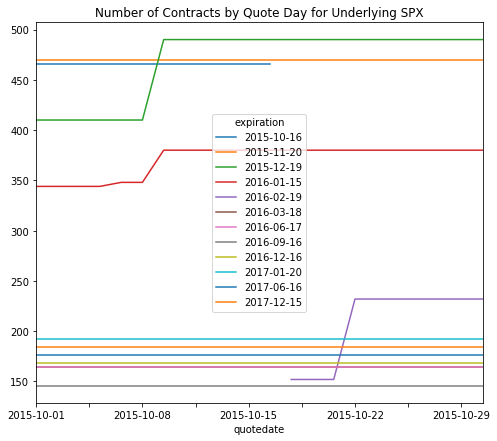

In [11]:
tmp = spx.loc[spx.underlying=='SPX'].groupby(['quotedate','expiration']).underlying.count().unstack()
tmp.plot(figsize=(8,7), title='Number of Contracts by Quote Day for Underlying SPX');

In [12]:
# Full Data for an out-ot-money Put
spx.loc[spx.optionalias=='SPXW160930P01700000']

,underlying,underlying_last,exchange,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,time_to_expiration
11564,SPXW,1921.42,W,put,2016-09-30,2015-10-01,1700,96.0,89.2,91.0,2,8,0.2527,-0.2663,0.0007,-77.8616,630.3930,SPXW160930P01700000,1.000000
23158,SPXW,1948.51,W,put,2016-09-30,2015-10-02,1700,96.0,80.8,83.0,0,10,0.2511,-0.2474,0.0006,-75.6754,614.3707,SPXW160930P01700000,0.997260
34336,SPXW,1987.89,W,put,2016-09-30,2015-10-05,1700,96.0,70.8,72.8,0,10,0.2507,-0.2220,0.0006,-72.9999,587.9129,SPXW160930P01700000,0.989041
45514,SPXW,1981.01,W,put,2016-09-30,2015-10-06,1700,96.0,72.3,75.5,0,10,0.2520,-0.2268,0.0006,-74.1035,592.1300,SPXW160930P01700000,0.986301
56704,SPXW,1991.76,W,put,2016-09-30,2015-10-07,1700,96.0,67.4,69.5,0,10,0.2471,-0.2170,0.0006,-71.3567,579.7932,SPXW160930P01700000,0.983562
67918,SPXW,2012.74,W,put,2016-09-30,2015-10-08,1700,96.0,62.2,65.1,0,10,0.2467,-0.2042,0.0006,-69.5996,564.4995,SPXW160930P01700000,0.980822
79356,SPXW,2014.54,W,put,2016-09-30,2015-10-09,1700,96.0,62.4,64.3,0,10,0.2472,-0.2033,0.0006,-69.7205,562.6913,SPXW160930P01700000,0.978082
90410,SPXW,2016.16,W,put,2016-09-30,2015-10-12,1700,96.0,59.3,61.3,0,10,0.2433,-0.1990,0.0006,-68.0947,553.6702,SPXW160930P01700000,0.969863
101464,SPXW,2003.02,W,put,2016-09-30,2015-10-13,1700,96.0,63.5,65.3,0,10,0.2462,-0.2084,0.0006,-70.4609,564.6686,SPXW160930P01700000,0.967123
112518,SPXW,1992.73,W,put,2016-09-30,2015-10-14,1700,96.0,67.6,69.3,0,10,0.2498,-0.2167,0.0006,-72.8534,573.8441,SPXW160930P01700000,0.964384


**Verify Data**

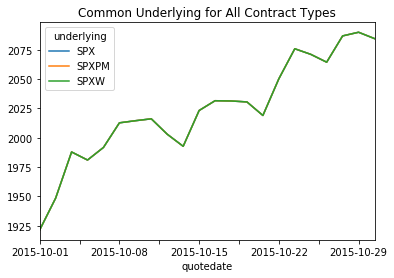

In [13]:
tmp = spx[['quotedate','underlying_last','underlying']].drop_duplicates()
tmp.groupby(['quotedate','underlying']).underlying_last.min().unstack().\
plot(title='Common Underlying for All Contract Types');

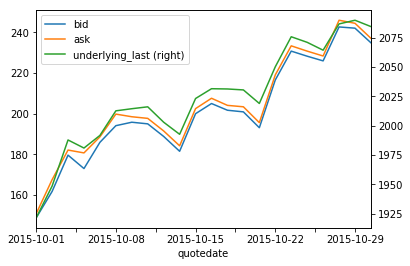

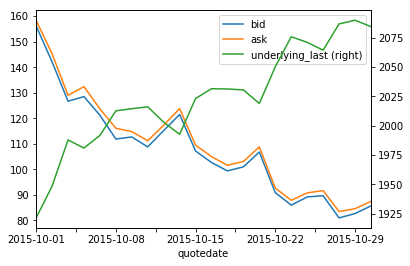

In [14]:
tmp = spx.loc[(spx.underlying=='SPXW') & (spx.expiration=='2016-09-30') & (spx.strike==1900)]
tmp.loc[tmp.type=='call'].plot(x='quotedate',
                               y=['bid','ask','underlying_last'],secondary_y='underlying_last');
tmp.loc[tmp.type=='put'].plot(x='quotedate',
                              y=['bid','ask','underlying_last'],secondary_y='underlying_last');

### Trading versus Time to Expiration

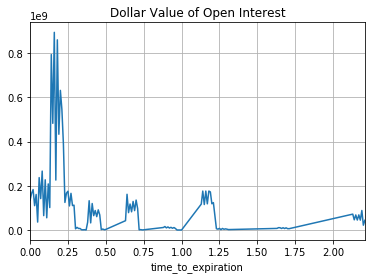

In [15]:
tmp = spx.loc[spx['openinterest']>0][['time_to_expiration','openinterest','volume','last','bid','ask']]
tmp['oiv'] = (tmp['bid']+tmp['ask'])/2 * tmp.openinterest
tmp.time_to_expiration = tmp.time_to_expiration.round(2)
tmp.groupby('time_to_expiration').oiv.sum().plot(title='Dollar Value of Open Interest',grid=True);

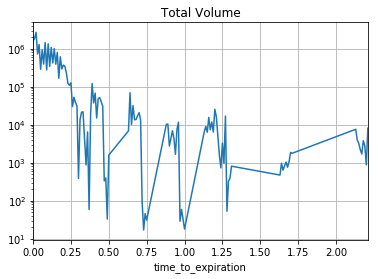

In [16]:
tmp.groupby('time_to_expiration').volume.sum().plot(title='Total Volume',grid=True,logy=True);

### Implied Volatility
The variation of implied volatility within the same trading day is remarkable.

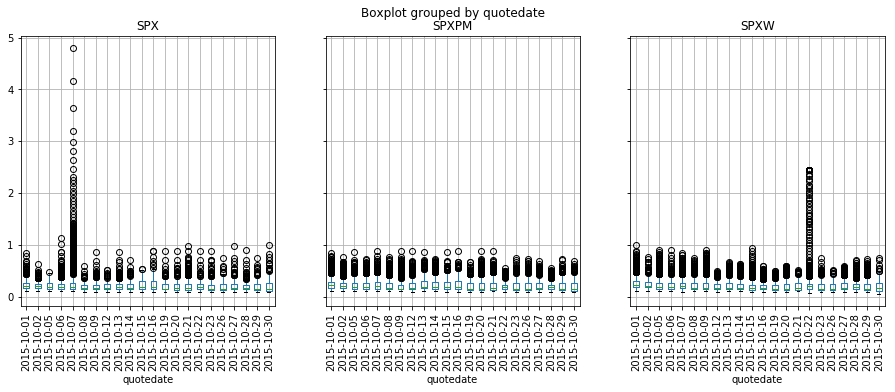

In [17]:
spx.groupby('underlying').boxplot(column='impliedvol',by='quotedate',
        layout=(1,3),figsize=(15,5),grid=True, rot=90);

### Historical Volatility

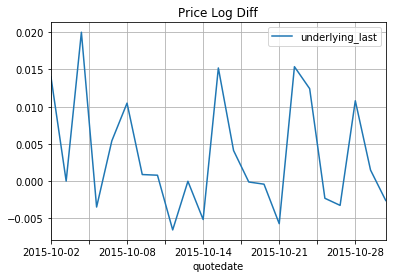

In [18]:
p = spx[['quotedate','underlying_last']].drop_duplicates().set_index('quotedate')
x = np.log(p).diff().dropna()
x.plot(grid=True,title='Price Log Diff');

In [19]:
# Total Return
r = (p.iloc[-1]-p.iloc[0])/p.iloc[0]
r = r.iloc[0]
print('Total Return (October 2015) = {:7.2%}'.format(r))
print('Total Return (Annualized)   = {:7.2%}'.format(12 * r))

Total Return (October 2015) =   8.49%
Total Return (Annualized)   = 101.90%


In [20]:
trade_days_per_year = len(x) * 12

In [21]:
x.mean()

underlying_last    0.003544
dtype: float64

In [22]:
# Total Return for Oct 2015 (Estimated)
x.sum()

underlying_last    0.081503
dtype: float64

In [23]:
# Based on Short History
vol = x.std() * np.sqrt(trade_days_per_year)
print('Historical Volatility Estimate (Annualized) = {:7.2%}'.format(vol.iloc[0]))

Historical Volatility Estimate (Annualized) =  12.97%


In [24]:
# Median Implied Volatility

vol2 = spx.impliedvol.median()
print('Median Implied Volatility (Annualized) = {:7.2%}'.format(vol2))

Median Implied Volatility (Annualized) =  17.38%


### Volatility Smile & Market Maker Strategy

In [914]:
spx.loc[(spx.type=='put') & (spx.quotedate=='2015-10-01') & (spx.underlying=='SPXW')].expiration.drop_duplicates()

5956     2015-10-02
6373     2015-10-09
6790     2015-10-23
7209     2015-10-30
7627     2015-11-06
8020     2015-11-13
8392     2015-11-27
8793     2015-11-30
9189     2015-12-04
9561     2015-12-11
9942     2015-12-24
10347    2015-12-31
10735    2016-01-08
11029    2016-01-29
11210    2016-02-29
11330    2016-03-31
11431    2016-06-30
11533    2016-09-30
Name: expiration, dtype: object

#### Near Maturity Put

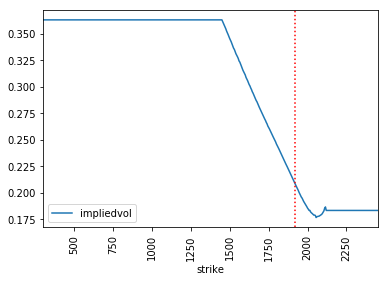

In [917]:
tmp = spx.loc[(spx.type=='put') & (spx.expiration=='2015-12-04') & (spx.quotedate=='2015-10-01')]
tmp = tmp.loc[(spx.underlying=='SPXW')]
ax = tmp.plot(y='impliedvol',x='strike',rot=90)
ax.axvline(tmp.underlying_last.iloc[0],color='r',linestyle=':');

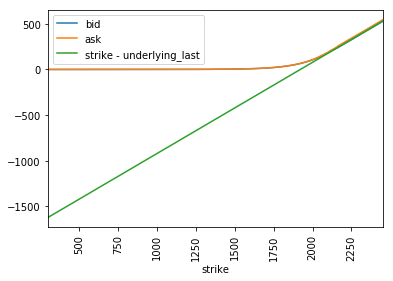

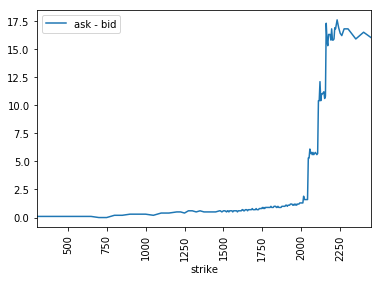

In [27]:
tmp['strike - underlying_last'] = tmp.strike - tmp.underlying_last
tmp.plot(y=['bid','ask','strike - underlying_last'],x='strike',rot=90)
tmp['ask - bid'] = tmp.ask - tmp.bid
tmp.plot(y='ask - bid',x='strike',rot=90);

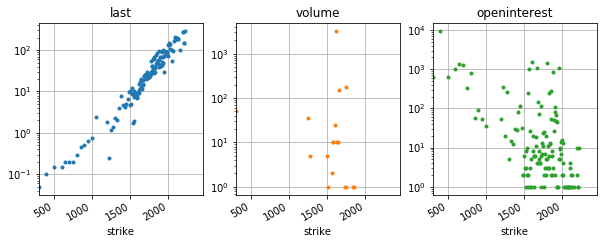

In [28]:
cols = ['last','volume','openinterest']
tmp.set_index('strike')[cols].plot(style='.',
        layout=(1,3),subplots=True,figsize=(10,3.5),legend=False,title=cols,grid=True,logy=True);

#### Long Dated Put

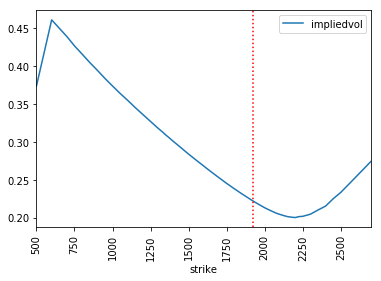

In [918]:
tmp = spx.loc[(spx.type=='put') & (spx.expiration=='2016-09-30') & (spx.quotedate=='2015-10-01')]
tmp = tmp.loc[(spx.underlying=='SPXW')]
ax = tmp.plot(y='impliedvol',x='strike',rot=90)
ax.axvline(tmp.underlying_last.iloc[0],color='r',linestyle=':');

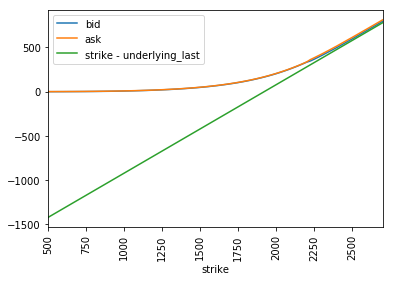

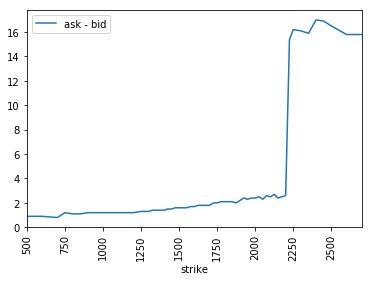

In [30]:
tmp['strike - underlying_last'] = tmp.strike - tmp.underlying_last
tmp.plot(y=['bid','ask','strike - underlying_last'],x='strike',rot=90)
tmp['ask - bid'] = tmp.ask - tmp.bid
tmp.plot(y='ask - bid',x='strike',rot=90);

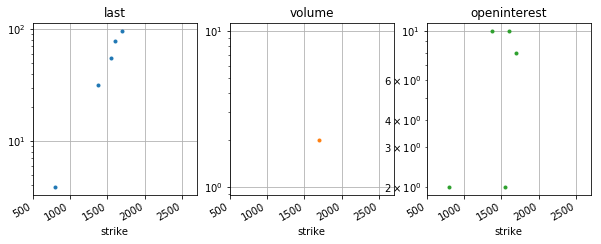

In [31]:
cols = ['last','volume','openinterest']
tmp.set_index('strike')[cols].plot(style='.',
        layout=(1,3),subplots=True,figsize=(10,3.5),legend=False,title=cols,grid=True,logy=True);

In [399]:
# Detailed Table
#tmp.iloc[:,6:13].style.background_gradient(subset=['last','volume','openinterest'])

# Option Price Calculators

## Black-Scholes Formulas

In [354]:
from scipy.stats import norm

# S: underlying stock price
# K: Option strike price
# r: continuously compounded risk-free interest rate (% p.a.)
# q: continuously compounded dividend yield (% p.a.)
# vol: volatility (% p.a.)
# T: time to expiration (% of year)

def d1_calc(S, K, r, q, vol, T, **kwargs):
    # Calculates d1 in the BSM equation
    return (np.log(S/K) + (r - q + 0.5 * vol**2)*T)/(vol*np.sqrt(T+1e-9))

def BS_call(S, K, r, q, vol, T, d1, **kwargs):
    d2 = d1 - vol * np.sqrt(T)
    return S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def BS_put(S, K, r, q, vol, T, d1, **kwargs):
    return BS_call(S, K, r, q, vol, T, d1) - S * np.exp(-q*T) + K * np.exp(-r*T)

def eu_option_price(S, K, r, q, vol, T, d1, otype, **kwargs):
    if otype=='call':
        return BS_call(S, K, r, q, vol, T, d1, **kwargs)
    elif otype=='put':
        return BS_put(S, K, r, q, vol, T, d1, **kwargs)
eu_option_price.name = 'EU Price'

def eu_option_price_tot(S, K, r, q, vol, T, otype, **kwargs):
    d1 = d1_calc(S, K, r, q, vol, T)
    if otype=='call':
        return BS_call(S, K, r, q, vol, T, d1, **kwargs)
    elif otype=='put':
        return BS_put(S, K, r, q, vol, T, d1, **kwargs)
eu_option_price_tot.name = 'EU Price'

###########################################################################

#1st Order Greeks

def delta(q, T, d1, otype, **kwargs):
    if(otype == "call"):
        delta = np.exp(-q*T) * norm.cdf(d1)
    elif(otype == "put"):
        delta = -np.exp(-q*T) * norm.cdf(-d1)
    return delta
delta.name = 'delta'

def vega(S, q, T, d1, otype, **kwargs):
    return S * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)
vega.name = 'vega'

def rho(S, K, r, vol, T, d1, otype, **kwargs):
    d2 = d1 - vol * np.sqrt(T)
    if(otype == "call"):
        rho = K * T * np.exp(-r*T) * norm.cdf(d2)
    elif(otype == "put"):
        rho = - K * T * np.exp(-r*T) * norm.cdf(-d2)
    return rho
rho.name = 'rho'

def theta(S, K, r, q, vol, T, d1, otype, **kwargs):
    d2 = d1 - vol * np.sqrt(T)
    theta  = -S * vol * np.exp(-q*T) * norm.pdf(d1) / (2 * np.sqrt(T+1e-9))
    if(otype == "call"):
        theta -= r * K * np.exp(-r*T) * norm.cdf(d2)
        theta += q * S * np.exp(-q*T) * norm.cdf(d1)
    elif(otype == "put"):
        theta += r * K * np.exp(-r*T) * norm.cdf(-d2)
        theta -= q * S * np.exp(-q*T) * norm.cdf(-d1)
    return theta /  (T+1e-9)
theta.name = 'theta'

#2nd Order Greeks

# Gamma for calls/puts the same
def gamma(S, K, r, q, vol, T, d1, otype, **kwargs):
    gamma = np.exp(-q*T) * norm.pdf(d1) / (S * vol * np.sqrt(T+1e-9))
    return gamma
gamma.name = 'gamma'

In [147]:
# European Option
maturity_date    = date(2016, 1, 15)
calculation_date = date(2015, 5, 8 )
spot_price = 127.62
strike_price = 130
volatility = 0.20
dividend_rate =  0.0163
risk_free_rate = 0.001

params = {
    'S':spot_price,
    'K':strike_price,
    'r':risk_free_rate,
    'q':dividend_rate,
    'vol':volatility,
    'T':(maturity_date-calculation_date).days / 365
}

In [148]:
d1 = d1_calc(**params)
params['d1'] = d1
p_call = params.copy()
p_put  = params.copy()
p_call['otype'] = 'call'
p_put['otype'] = 'put'

In [149]:
print('EU Call Price = ', BS_call(**p_call))
print('EU Put  Price = ', BS_put(**p_put))

EU Call Price =  6.749271812460599
EU Put  Price =  10.467695348619742


In [37]:
eval_eu_option = {
    f.name:[f(**p_call),f(**p_put)]
    for f in [eu_option_price,delta,vega,rho,theta,gamma]
}

In [38]:
pd.DataFrame(eval_eu_option,index=['call','put'])

,EU Price,delta,vega,rho,theta,gamma
call,6.749272,0.458297,41.655352,35.720889,-7.432965,0.018522
put,10.467695,-0.530512,41.655352,-53.970590,-10.224081,0.018522


In [39]:
# Expect EU Call Price = 6.75

## Binary Option Pricing Model

In [40]:
def US_Options_Value(S, K, r, vol, T, q = 0, n = 100, **kwargs):
    '''
    Returns Value of American Options Using Binomial Model
    
    S: Underlying Price
    K: Strike Price
    r: Risk Free Rate
    vol: Volatility
    T: Time to Maturity
    q: Dividend Rate
    n: Number of Epochs
    '''
    deltaT = T/n   # Delta Time
    u = np.exp(vol*np.sqrt(deltaT)) # Up Factor
    p = (u * np.exp((r-q) * deltaT) - 1) / (u**2 - 1) # risk neutral prob
    df = np.exp(-r * deltaT) # discount factor
    
    p0 = p * df
    p1 = (1-p) * df
    
    n += 1
    
    e_ = np.cumsum(np.ones(n))

    ov_call = np.zeros(n+1)           # option value call last period
    ov_put  = np.zeros(n+1)           # option value put  last period
    s = S * u ** (2 * e_ - n - 1)     # stock value last period
    
    while n > 0:

        ov_call = np.maximum(s-K,p0*ov_call[1:]+p1*ov_call[:-1])
        ov_call = np.maximum(0,ov_call[:n])
        ov_put  = np.maximum(K-s,p0*ov_put[1:]+p1*ov_put[:-1])
        ov_put  = np.maximum(0,ov_put[:n])
        n -= 1
        s = s[:n] * u
    
    return ov_call[0], ov_put[0]

%timeit  US_Options_Value(100, 105, 0.06, 0.4, 1.)

1.76 ms ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
# Test
# US_Options_Value(100, 105, 0.06, 0.4, 1.) = (16.36012102695285, 16.07392360356661)
US_Options_Value(100, 105, 0.06, 0.4, 1.)

(16.360121026953376, 16.073923603566143)

In [42]:
for n in [20,100,1000,5000,10000,50000]:
    %time est_ = US_Options_Value(100, 105, 0.06, 0.4, 1., n=n)
    print('\nn = {:7,d}'.format(n), 'Estimate: Put {:8.5f} Call {:8.5f}'.format(*est_))
    print('-'*48, '\n'*3)

CPU times: user 481 µs, sys: 4 µs, total: 485 µs
Wall time: 497 µs

n =      20 Estimate: Put 16.43190 Call 16.17278
------------------------------------------------ 



CPU times: user 1.85 ms, sys: 5 µs, total: 1.86 ms
Wall time: 1.88 ms

n =     100 Estimate: Put 16.36012 Call 16.07392
------------------------------------------------ 



CPU times: user 27.4 ms, sys: 1.75 ms, total: 29.2 ms
Wall time: 28.6 ms

n =   1,000 Estimate: Put 16.32503 Call 16.04372
------------------------------------------------ 



CPU times: user 228 ms, sys: 5.58 ms, total: 234 ms
Wall time: 234 ms

n =   5,000 Estimate: Put 16.32758 Call 16.04505
------------------------------------------------ 



CPU times: user 833 ms, sys: 37.1 ms, total: 870 ms
Wall time: 871 ms

n =  10,000 Estimate: Put 16.32693 Call 16.04449
------------------------------------------------ 



CPU times: user 19.3 s, sys: 368 ms, total: 19.7 s
Wall time: 20 s

n =  50,000 Estimate: Put 16.32712 Call 16.04455
------------------

> This algorithm does not scale well with n. In the following we will be using n = 1,000.

## Implied Volatility Calculation

In [337]:
from scipy.optimize import minimize_scalar

In [338]:
def eu_price_dev_given_vol(S, K, r, q, T, otype, p_est, **kwargs):
    if otype == 'call':
        return lambda v: abs(BS_call(S, K, r, q, v, T, d1_calc(S, K, r, q, v, T))-p_est)
    elif otype == 'put':
        return lambda v: abs(BS_put(S, K, r, q, v, T, d1_calc(S, K, r, q, v, T)) -p_est)

In [339]:
def us_price_dev_given_vol(S, K, r, q, T, otype, p_est, **kwargs):
    if otype == 'call':
        return lambda v: abs(US_Options_Value(S, K, r, v, T, q, n = 1000)[0]-p_est)
    elif otype == 'put':
        return lambda v: abs(US_Options_Value(S, K, r, v, T, q, n = 1000)[1]-p_est)

### Example: Dividend Carrying Call

In [340]:
# Example
p = {'S': 1921.42,'otype': 'call','K': 1875,'impliedvol': 0.2416,
     'T': 0.0410958904109589,'r': 0.002,'q': 0.02,'p_est':64}

In [341]:
%%time
soln = minimize_scalar(eu_price_dev_given_vol(**p),(0.1,.25,0.6),method='golden',tol=1e-3)
print(soln)
#soln.x

     fun: 0.0003899375783475989
    nfev: 19
     nit: 14
 success: True
       x: 0.24286037937535834
CPU times: user 4.59 ms, sys: 752 µs, total: 5.35 ms
Wall time: 4.69 ms


In [342]:
%%time
soln = minimize_scalar(us_price_dev_given_vol(**p),(0.1,.25,0.6),method='golden',tol=1e-3)
print(soln)

     fun: 0.007698577119690242
    nfev: 19
     nit: 14
 success: True
       x: 0.24164078658194837
CPU times: user 434 ms, sys: 2.26 ms, total: 436 ms
Wall time: 436 ms


### Example: Non Dividend Carrying Put

In [343]:
# Example
p = {'S': 1921.42,'otype': 'put','K': 1875,'impliedvol': 0.2416,
     'T': 0.0410958904109589,'r': 0.002,'q': 0.00,'p_est':25}

In [344]:
%%time
soln = minimize_scalar(eu_price_dev_given_vol(**p),(0.1,.25,0.6),method='golden',tol=1e-3)
print(soln)
#soln.x

     fun: 0.00017159349272333202
    nfev: 20
     nit: 15
 success: True
       x: 0.28968144530240736
CPU times: user 5.41 ms, sys: 832 µs, total: 6.24 ms
Wall time: 5.55 ms


In [345]:
%%time
soln = minimize_scalar(us_price_dev_given_vol(**p),(0.1,.25,0.6),method='golden',tol=1e-3)
print(soln)

     fun: 0.0018816776064625174
    nfev: 20
     nit: 15
 success: True
       x: 0.2895834335510499
CPU times: user 461 ms, sys: 2.38 ms, total: 463 ms
Wall time: 464 ms


### Putting It All Together
Using the faster EU Price calculator as we apply this analysis to total return indices. Total return indices have zero dividend yield and the US option calculator should product similar results to the EU one.

In [780]:
def iv_estimate(S, K, r, q, T, otype, p_est, bracket=[0.01,0.1,0.6], **kwargs):
    f = eu_price_dev_given_vol(S, K, r, q, T, otype, p_est)
    return minimize_scalar(f,bracket,method='golden',tol=1e-4).x

In [781]:
%%timeit
iv_estimate(**p)

3.86 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Option Formulas Applied to SPX

In [54]:
spx['risk_free_rate'] = 0.002
spx['dividend_rate'] = 0.0
#spx['volatility'] = 0.17
spx['volatility'] = spx['impliedvol']

In [104]:
corresp = {'underlying_last':'S', 'strike':'K', 'risk_free_rate':'r',
           'dividend_rate':'q', 'volatility':'vol', 'time_to_expiration':'T',
           'type':'otype','price':'p_est'}

In [56]:
key_vars = ['underlying_last','type','expiration','quotedate','strike','last','bid','ask','volume',
           'openinterest','impliedvol','delta','gamma','theta','vega']

In [57]:
def run_case(case):
    display(case[key_vars].to_frame())
    p = case.rename(corresp).to_dict()
    tidx = 0 if case.type == 'call' else 1
    
    p['d1'] = d1_calc(**p)
    eval_option = {
        f.name:[f(**p)]
        for f in [eu_option_price,delta,vega,rho,theta,gamma]
    }
    
    eval_option['US Price'] = US_Options_Value(**p, n=1000)[tidx]
    cols = ['US Price', 'EU Price', 'delta', 'vega', 'rho', 'theta', 'gamma']
    display(pd.DataFrame(eval_option,index=[ex.type],columns=cols).style.format('{:.2f}'))

## Near Maturity Call Close to Money

In [58]:
ex = spx.loc[(spx.expiration < '2015-11-31') & (np.abs(spx.strike-spx.underlying_last) < 50) & (spx.type=='call')].iloc[0]

In [59]:
run_case(ex)

,137
underlying_last,1921.42
type,call
expiration,2015-10-16
quotedate,2015-10-01
strike,1875
last,59
bid,62.4
ask,66.1
volume,88
openinterest,945


,US Price,EU Price,delta,vega,rho,theta,gamma
call,64.93,64.93,0.70,135.35,52.64,-9743.72,0.00


## Near Maturity Put Close to Money

In [60]:
ex = spx.loc[(spx.expiration < '2015-11-31') & (np.abs(spx.strike-spx.underlying_last) < 50) & (spx.type=='put')].iloc[0]

In [61]:
run_case(ex)

,370
underlying_last,1921.42
type,put
expiration,2015-10-16
quotedate,2015-10-01
strike,1875
last,16.77
bid,16
ask,17.8
volume,1612
openinterest,44708


,US Price,EU Price,delta,vega,rho,theta,gamma
put,17.64,17.64,-0.30,134.59,-24.09,-9386.84,0.00


## Longer-Dated Call Close to Money

In [62]:
ex = spx.loc[(spx.expiration > '2016-11-31') & (np.abs(spx.strike-spx.underlying_last) < 50) & (spx.type=='call')].iloc[0]

In [63]:
run_case(ex)

,2215
underlying_last,1921.42
type,call
expiration,2016-12-16
quotedate,2015-10-01
strike,1875
last,156.7
bid,171.5
ask,178.2
volume,0
openinterest,2880


,US Price,EU Price,delta,vega,rho,theta,gamma
call,173.52,173.55,0.59,820.45,1169.81,-50.97,0.00


## Longer-Dated Put Close to Money

In [64]:
ex = spx.loc[(spx.expiration > '2016-11-31') & (np.abs(spx.strike-spx.underlying_last) < 50) & (spx.type=='put')].iloc[0]

In [65]:
run_case(ex)

,2299
underlying_last,1921.42
type,put
expiration,2016-12-16
quotedate,2015-10-01
strike,1875
last,184.1
bid,160.6
ask,167.3
volume,0
openinterest,3944


,US Price,EU Price,delta,vega,rho,theta,gamma
put,165.72,165.45,-0.41,821.00,-1149.73,-62.45,0.00


## Near Maturity Call Deep In-the-Money

In [66]:
ex = spx.loc[(spx.expiration < '2015-11-31') & (spx.strike-spx.underlying_last < 500) & (spx.type=='call')].iloc[0]

In [67]:
run_case(ex)

,0
underlying_last,1921.42
type,call
expiration,2015-10-16
quotedate,2015-10-01
strike,400
last,0
bid,1518.7
ask,1525.2
volume,0
openinterest,0


,US Price,EU Price,delta,vega,rho,theta,gamma
call,1521.45,1521.45,1.00,0.00,16.44,-19.47,0.00


## Near Maturity Put Deep In-the-Money

In [68]:
ex = spx.loc[(spx.expiration < '2015-11-31') & (spx.strike-spx.underlying_last > 500) & (spx.type=='put')].iloc[0]

In [69]:
run_case(ex)

,462
underlying_last,1921.42
type,put
expiration,2015-10-16
quotedate,2015-10-01
strike,2450
last,0
bid,524.4
ask,530.9
volume,0
openinterest,0


,US Price,EU Price,delta,vega,rho,theta,gamma
put,528.58,528.38,-1.00,0.00,-100.68,119.22,0.00


# India's Nifty 50

## Underlying Index Data

In [70]:
from nsepy import get_history
from datetime import date
nifty = get_history(symbol="NIFTY", index=True, start=date(2018,1,1), end=date(2019,5,1))

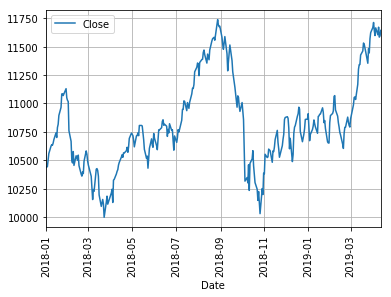

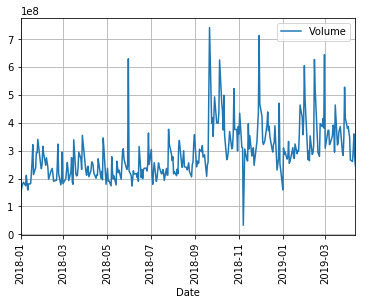

In [71]:
nifty[['Close']].plot(rot=90,grid=True);
nifty[['Volume']].plot(rot=90,grid=True);

In [72]:
# Index Returns
ret = np.log(nifty.Close).diff()

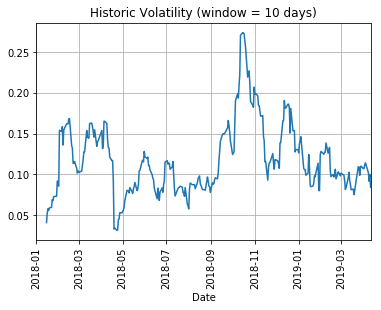

In [73]:
hist_vol = ret.rolling(10).std() * np.sqrt(252)
hist_vol.plot(rot=90,title='Historic Volatility (window = 10 days)',grid=True);

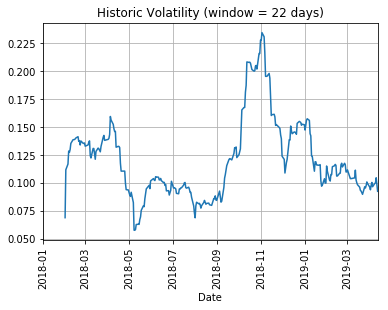

In [74]:
(ret.rolling(22).std() * np.sqrt(252)).plot(rot=90,title='Historic Volatility (window = 22 days)',grid=True);

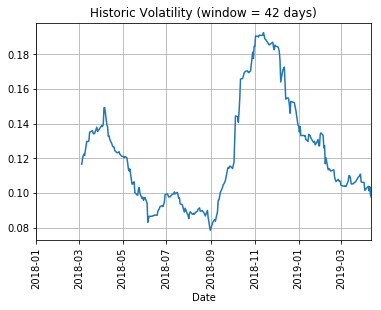

In [75]:
(ret.rolling(42).std() * np.sqrt(252)).plot(rot=90,title='Historic Volatility (window = 42 days)',grid=True);

## Option Data

### Data Garthering

In [820]:
from nsepy.derivatives import get_expiry_date
get_expiry_date(year=2018, month=12)

datetime.date(2018, 12, 27)

In [864]:
nifties = [get_history(symbol="NIFTY",start=date(2018,1,1),end=date(2019,5,1),
                        option_type=ot,strike_price=sp,expiry_date=edt,index=True)
           for edt in [date(2018,12,27),date(2019,1,31),date(2019,2,28),date(2019,3,28),date(2019,4,25)] 
           for ot in ['CE','PE']
           for sp in range(10300,12100,100)]

>For stock options, specify: option_type as “CE” for call and as “PE” for put option

In [865]:
nifty_opt = pd.concat(nifties)

In [866]:
nifty_opt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24124 entries, 2018-01-01 to 2019-04-12
Data columns (total 16 columns):
Symbol                 24124 non-null object
Expiry                 24124 non-null object
Option Type            24124 non-null object
Strike Price           24124 non-null float64
Open                   24124 non-null float64
High                   24124 non-null float64
Low                    24124 non-null float64
Close                  24124 non-null float64
Last                   24124 non-null float64
Settle Price           24124 non-null float64
Number of Contracts    24124 non-null object
Turnover               24124 non-null float64
Premium Turnover       24124 non-null float64
Open Interest          24124 non-null object
Change in OI           24124 non-null object
Underlying             14808 non-null float64
dtypes: float64(10), object(6)
memory usage: 3.1+ MB


In [867]:
hist_vol.name='volatility'

In [868]:
tmp = pd.merge(nifty_opt.reset_index(),hist_vol.reset_index(),sort=False,on='Date',how='left')

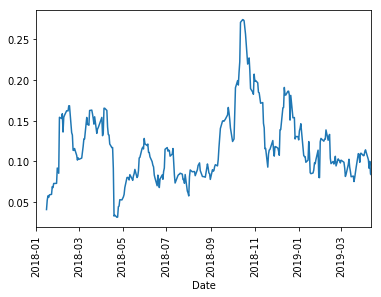

In [869]:
tmp.set_index('Date',inplace=True)
tmp.volatility.plot(rot=90);

In [870]:
tmp = pd.merge(tmp,nifty.Close.rename('underlying_last').reset_index(),sort=False,
               left_on='Date',right_on='Date',how='left')

In [871]:
del tmp['Underlying']

In [872]:
tmp.set_index('Date',inplace=True)

In [873]:
import quandl
qk = !cat ~/.quandl_key
quandl.ApiConfig.api_key = qk[0] # Use need your own key from Quandl here. It is free!

In [874]:
bond_rate_india = quandl.get("OECD/KEI_IRLTLT01_IND_ST_M")

In [875]:
bond_rate_india = bond_rate_india['2017-12-31':] / 100

In [876]:
tmp2 = tmp.join(bond_rate_india.Value.rename('risk_free_rate'),how='outer').sort_index()
tmp2['risk_free_rate'] = tmp2['risk_free_rate'].ffill()

In [877]:
nifty_opt = tmp2['2018-04-02':].reset_index().\
    rename(columns={'Expiry':'expiration', 'Number of Contracts':'volume',
                    'Settle Price':'price','Strike Price':'strike','Option Type':'type',
                     'Open Interest':'openinterest','Date':'quotedate','Symbol':'underlying'})

In [878]:
nifty_opt['time_to_expiration'] = (pd.to_datetime(nifty_opt.expiration)-nifty_opt.quotedate).astype('timedelta64[D]') / 365
nifty_opt['dividend_rate'] = 0.
nifty_opt['type'] = np.where(nifty_opt['type']=='CE','call','put')

In [879]:
nifty_opt.strike.describe()

count    21964.000000
mean     11148.925514
std        518.421942
min      10300.000000
25%      10700.000000
50%      11100.000000
75%      11600.000000
max      12000.000000
Name: strike, dtype: float64

In [880]:
nifty_opt.head()

,quotedate,underlying,expiration,type,strike,Open,High,Low,Close,Last,...,volume,Turnover,Premium Turnover,openinterest,Change in OI,volatility,underlying_last,risk_free_rate,time_to_expiration,dividend_rate
0,2018-04-02,NIFTY,2018-12-27,call,10300.0,0.0,0.0,0.0,932.00,932.0,...,0,0.0,0.0,75,0,0.154033,10211.8,0.07608,0.736986,0.0
1,2018-04-02,NIFTY,2018-12-27,call,10400.0,0.0,0.0,0.0,500.00,500.0,...,0,0.0,0.0,24000,0,0.154033,10211.8,0.07608,0.736986,0.0
2,2018-04-02,NIFTY,2018-12-27,call,10500.0,446.9,489.9,430.5,476.70,489.9,...,312,256353000.0,10653000.0,180300,8250,0.154033,10211.8,0.07608,0.736986,0.0
3,2018-04-02,NIFTY,2018-12-27,call,10600.0,0.0,0.0,0.0,1392.50,0.0,...,0,0.0,0.0,0,0,0.154033,10211.8,0.07608,0.736986,0.0
4,2018-04-02,NIFTY,2018-12-27,call,10700.0,0.0,0.0,0.0,1601.15,0.0,...,0,0.0,0.0,0,0,0.154033,10211.8,0.07608,0.736986,0.0


### Nifty Quick Stats

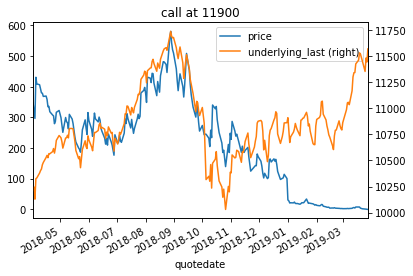

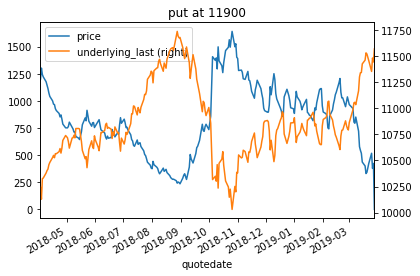

In [881]:
tmp = nifty_opt.loc[(nifty_opt.expiration==pd.datetime(2019, 3, 28).date()) & (np.abs(nifty_opt.strike-11900) < 1)]
tmp.loc[tmp.type=='call'].plot(x='quotedate',y=['price','underlying_last'],
                             secondary_y='underlying_last',title='call at 11900');
tmp.loc[tmp.type=='put'].plot(x='quotedate',y=['price','underlying_last'],
                             secondary_y='underlying_last',title='put at 11900');

### Estimate and Append Nifty Option Greeks

In [882]:
iv_bracket = [0.0001, 0.10, 0.50] # Implied Volatility Line Search Starting Values
def greeks(S, K, r, q, vol, T, otype, p_est, **kwargs):
    ovp = eu_option_price(S, K, r, q, vol, T, d1_calc(S, K, r, q, vol, T), otype)
    dlt = delta(q, T, d1, otype)
    vga = vega(S, q, T, d1, otype)
    rh_ = rho(S, K, r, vol, T, d1, otype)
    tht = theta(S, K, r, q, vol, T, d1, otype)
    gma = gamma(S, K, r, q, vol, T, d1, otype)
    try:
        ive = iv_estimate(S, K, r, q, T, otype, p_est, iv_bracket)
    except ValueError:
        ive = np.nan
    return pd.Series([ovp,dlt,vga,rh_,tht,gma,ive], 
                     index=['eu_price_bs','delta','vega','rho','theta','gamma','impliedvol'])

In [883]:
x = nifty_opt[corresp.keys()].rename(columns=corresp).apply(lambda x: greeks(**x),axis=1)

In [884]:
x.describe()

,eu_price_bs,delta,vega,rho,theta,gamma,impliedvol
count,21964.000000,21964.000000,21964.000000,21964.000000,2.196400e+04,21964.000000,20743.000000
mean,383.355395,-0.036516,2327.258937,-250.849379,-5.198067e+13,0.066772,0.150306
std,354.580050,0.500011,1032.701063,2356.506807,6.429375e+14,0.816313,0.042038
min,0.000000,-0.536516,0.000000,-6551.005276,-8.638239e+15,0.000205,0.055800
25%,82.813809,-0.536516,1528.626429,-1597.214162,-6.058465e+03,0.000464,0.118255
50%,288.658868,-0.036516,2156.247017,-0.000000,-1.502874e+03,0.000609,0.141571
75%,600.167967,0.463484,3243.620532,1210.982900,-3.556903e+02,0.000963,0.174568
max,1896.202141,0.463484,4074.250279,4733.251813,7.292821e+02,11.860025,0.400241


Couldn't compute IV for the following cases

In [885]:
focus = nifty_opt.loc[x.impliedvol.isna()].rename(columns=corresp)
focus.index

Int64Index([  722,   794,   866,   938,  1010,  1082,  1154,  1225,  1226,
             1298,
            ...
            21858, 21859, 21892, 21893, 21895, 21927, 21928, 21929, 21964,
            21965],
           dtype='int64', length=1223)

All problem cases are either in-the-money puts or at maturity

In [886]:
np.all((focus.otype=='put') | (focus['T']==0))

False

Moreover these in-of-money puts are near maturity and on average 5% in-of-money (underlying price < strike).

In [887]:
focus['T'][focus['T']>0].describe()

count    1077.000000
mean        0.261136
std         0.245468
min         0.002740
25%         0.021918
50%         0.265753
75%         0.468493
max         0.808219
Name: T, dtype: float64

In [888]:
(focus['K']/focus['S']-1)[focus['T']>0].describe()

count    1077.000000
mean       -0.013965
std         0.072944
min        -0.122545
25%        -0.076212
50%        -0.038886
75%         0.056382
max         0.137532
dtype: float64

The price of in-the-money puts **is minimized at 0 volatility**. Hence, their implied volatility cannot be calculated using line search methodology. We set implied volatility to 0 for these cases.

In [889]:
x.impliedvol[x.impliedvol.isna() & (nifty_opt.time_to_expiration > 0)] = 0

In [890]:
nifty_opt = pd.concat([nifty_opt,x],axis=1)

In [891]:
nifty_opt.describe()

,strike,Open,High,Low,Close,Last,price,Turnover,Premium Turnover,volatility,...,risk_free_rate,time_to_expiration,dividend_rate,eu_price_bs,delta,vega,rho,theta,gamma,impliedvol
count,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,2.196400e+04,2.196400e+04,21964.000000,...,21966.000000,21964.000000,21966.0,21964.000000,21964.000000,21964.000000,21964.000000,2.196400e+04,21964.000000,21820.000000
mean,11148.925514,143.957487,154.439779,133.648345,535.834215,189.454626,422.997134,6.006601e+09,3.887170e+07,0.119542,...,0.076844,0.351127,0.0,383.355395,-0.036516,2327.258937,-250.849379,-5.198067e+13,0.066772,0.142887
std,518.421942,258.406223,270.266430,246.915925,429.814283,292.301162,354.128821,3.263655e+10,1.639252e+08,0.043076,...,0.002280,0.269935,0.0,354.580050,0.500011,1032.701063,2356.506807,6.429375e+14,0.816313,0.052345
min,10300.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.031418,...,0.073475,0.000000,0.0,0.000000,-0.536516,0.000000,-6551.005276,-8.638239e+15,0.000205,0.000000
25%,10700.000000,0.000000,0.000000,0.000000,165.500000,0.000000,129.987500,0.000000e+00,0.000000e+00,0.087906,...,0.074300,0.123288,0.0,82.813809,-0.536516,1528.626429,-1597.214162,-6.058465e+03,0.000464,0.115339
50%,11100.000000,0.000000,0.000000,0.000000,454.750000,18.000000,340.700000,0.000000e+00,0.000000e+00,0.109575,...,0.077820,0.254795,0.0,288.658868,-0.036516,2156.247017,-0.000000,-1.502874e+03,0.000609,0.138539
75%,11600.000000,192.375000,215.000000,168.925000,812.700000,291.000000,645.862500,4.860963e+08,6.296250e+06,0.139098,...,0.078300,0.564384,0.0,600.167967,0.463484,3243.620532,1210.982900,-3.556903e+02,0.000963,0.172681
max,12000.000000,1830.000000,1864.500000,1746.000000,1857.100000,1854.850000,1877.750000,1.062938e+12,2.616982e+09,0.274080,...,0.080200,0.986301,0.0,1896.202141,0.463484,4074.250279,4733.251813,7.292821e+02,11.860025,0.400241


## Nifty Option Stats

### Variation of Implied Volatility
Total picture throughout the year-plus period. Far from maturity the trade is thin.

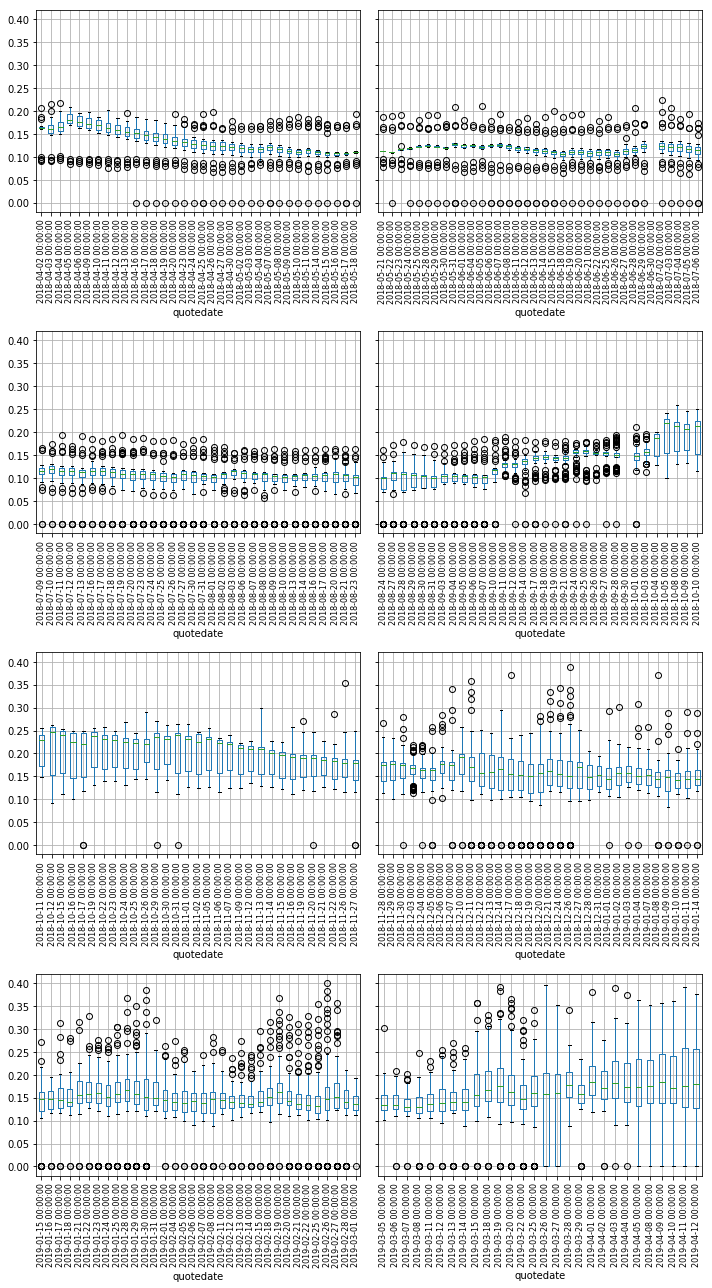

In [892]:
ax = nifty_opt.groupby(pd.Grouper(key='quotedate', freq='48D')).\
    boxplot(column='impliedvol',by='quotedate',rot=90,figsize=(10,18),layout=(4,2))
from matplotlib.dates import DateFormatter
myFmt = DateFormatter("%m/%d")
for pnl in ax: 
    #pnl.xaxis.set_major_formatter(myFmt)
    pnl.title.set_visible(False)
    pnl.tick_params(axis='x', which='major', labelsize=8)
plt.suptitle('')
plt.tight_layout()
plt.show()

This picture shows only data fon 2019 (close to maturity)

In [893]:
tmp = nifty_opt.loc[nifty_opt.impliedvol>0].set_index('quotedate')['2019-01-01':]

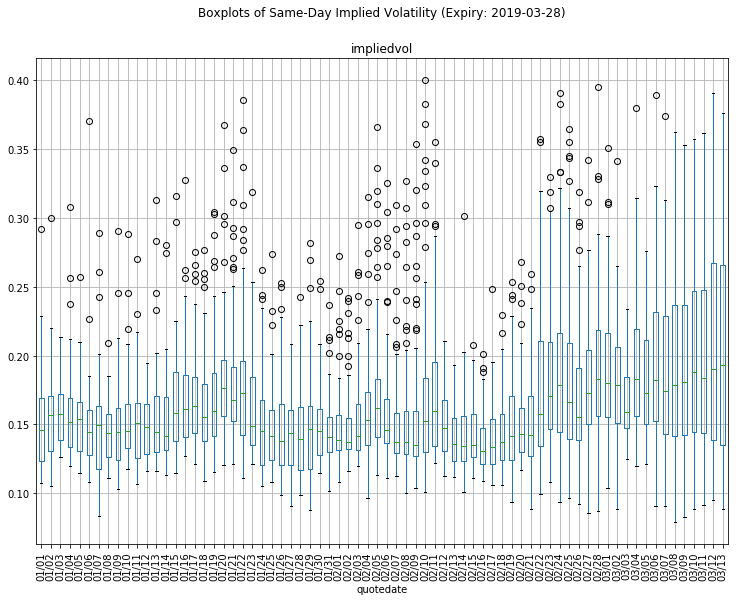

In [894]:
ax = tmp.boxplot(column='impliedvol',by='quotedate',rot=90,figsize=(12,9))
ax.xaxis.set_major_formatter(myFmt)
ax.get_figure().suptitle("Boxplots of Same-Day Implied Volatility (Expiry: 2019-03-28)");

### Nifty Volatility Smile

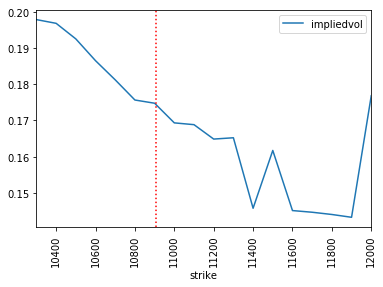

In [935]:
tmp = nifty_opt.loc[(nifty_opt.type=='put') & (nifty_opt.quotedate=='2019-01-17') & (nifty_opt.expiration==date(2019, 3, 28))]
tmp = tmp.copy()
ax = tmp.plot(y='impliedvol',x='strike',rot=90)
ax.axvline(tmp.underlying_last.iloc[0],color='r',linestyle=':');

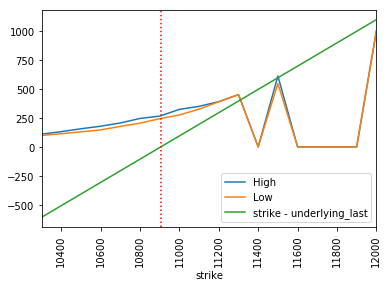

In [936]:
tmp['strike - underlying_last'] = tmp.strike - tmp.underlying_last
ax = tmp.plot(y=['High','Low','strike - underlying_last'],x='strike',rot=90)
ax.axvline(tmp.underlying_last.iloc[0],color='r',linestyle=':');

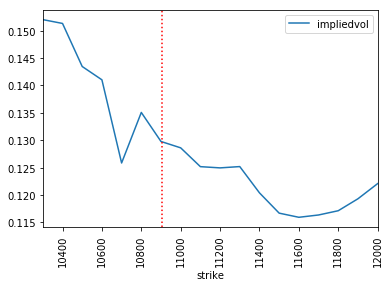

In [928]:
tmp = nifty_opt.loc[(nifty_opt.type=='call') & (nifty_opt.quotedate=='2019-01-17') & (nifty_opt.expiration==date(2019, 3, 28))]
tmp = tmp.copy()
ax = tmp.plot(y='impliedvol',x='strike',rot=90)
ax.axvline(tmp.underlying_last.iloc[0],color='r',linestyle=':');

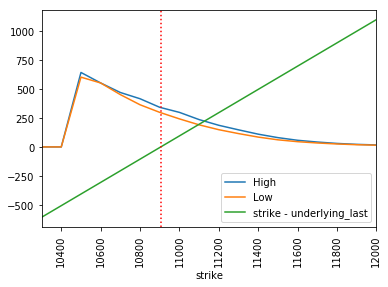

In [932]:
tmp['strike - underlying_last'] = tmp.strike - tmp.underlying_last
ax = tmp.plot(y=['High','Low','strike - underlying_last'],x='strike',rot=90)
ax.axvline(tmp.underlying_last.iloc[0],color='r',linestyle=':');

---

- This completes our analysis.